# Unbalanced Haar Treelet

This notebook explores an implementation of the Unbalanced Haar (UH) wavelet transform motivated by [Fryzlewicz (2018)](http://stats.lse.ac.uk/fryzlewicz/tguh/tguh.pdf). Given two sum variables $S_i = \frac{1}{\sqrt{n_i}}\sum_{l \in \mathcal{A}_i} x_l $ and $S_j = \frac{1}{\sqrt{n_j}}\sum_{l \in \mathcal{A}_j} x_l $ the UH transform obtains sum and difference variables by doing:

$\begin{pmatrix}
\text{sum}\\ 
\text{diff}
\end{pmatrix} = \begin{pmatrix}
a & b\\ 
-b & a
\end{pmatrix} \begin{pmatrix}
S_i\\ 
S_j
\end{pmatrix}$

Where $a = \sqrt{\frac{n_i}{n_i+n_j}}$ and $b = \sqrt{\frac{n_j}{n_i+n_j}}$. At every level in the algorithm sum variables generated by the UH transform are sums of merged variables in which each variable is given equal weight; the above definition of $S_i$ and $S_j$ is therefore justified. The UH transform is equivalent to rotating the basis vectors counter clockwise through an angle $\theta = \tan^{-1}(\sqrt{\frac{n_j}{n_i}})$. It can be shown that the UH transform satisfies Theorem 1 and Lemma 1 in the original [treelet paper](https://arxiv.org/abs/0707.0481). The UH transform may be preferable to local PCA for very large (p) datasets: it avoids repeatedly evaluating $\tan^{-1}$ in theory gives similar results to local PCA. 

When variables are negatively correlated UH merges lead to misleading results. Note that UH cannot rotate basis vectors clockwise, but when two variables are negatively correlated local PCA is equivalent to a clockwise rotation of the basis vectors. A solution is to transform basis vectors by $R(\theta)$: reflect basis vectors, apply standard UH rotation, re-reflect basis vectors. 

$R(\theta) = \begin{pmatrix}
1 & 0\\ 
0 & -1
\end{pmatrix} \begin{pmatrix}
\cos \theta & -\sin \theta\\ 
\sin \theta & \cos \theta
\end{pmatrix} \begin{pmatrix}
1 & 0\\ 
0 & -1
\end{pmatrix}$

This is equivalent to rotating basis vectors clockwise through an angle $\theta$ or doing: 

$\begin{pmatrix}
\text{sum}\\ 
\text{diff}
\end{pmatrix} = \begin{pmatrix}
a & -b\\ 
b & a
\end{pmatrix} \begin{pmatrix}
S_i\\ 
S_j
\end{pmatrix}$

## Setup

In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np 
import pandas as pd
import sys
import os

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [7]:
sys.path.append("../../modules")
from treelets import treelet_schemes as trees
from simulation_models import treelet_paper_models as model
from treelets import basis_selection as basis_selection
from treelets import treelet_plots

## Test: negative correlations

Consider the standard linear factor model with non-overlapping loadings explored in previous notebooks; this time let some of the variables be negatively ocrrelated. 

In [14]:
X = model.linear_mixture_model(V = np.array([[-1,1,-1,0,0,0,0,0,0,0],
                                            [0,0,0,-1,1,-1,-1,0,0,0],
                                            [0,0,0,0,0,0,0,-1,1,0]])\
                                    .transpose(),
                         C = 2*np.identity(3), 
                         sigma = 1, 
                         n = 1000)

In [15]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

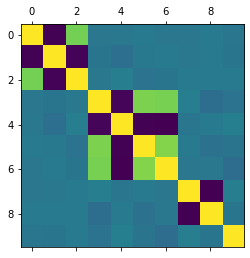

In [16]:
plt.matshow(np.cov(X.transpose()))

PCA will be able to recover the factor structure; again the eigne decomposition of the correlation matrix coincides with the factor structure. The standard treelet algorithm is not able to recover the factor structure; positively correlated variables are merged first but varaibles within the same "block" (i.e. which share common factors) can be negatively correlated. 

In [17]:
tree = trees.treelet(X = X,L = 9,abs_ = False)
loadings = basis_selection.best_basis(tree,3,X)[0]["basis"]
loadings

array([[ 0.70576098,  0.        , -0.0274683 ],
       [ 0.        ,  0.00125062,  0.        ],
       [ 0.70576098,  0.        , -0.0274683 ],
       [ 0.        ,  0.57260621,  0.        ],
       [ 0.02749986,  0.        ,  0.70657183],
       [ 0.        ,  0.57937946,  0.        ],
       [ 0.        ,  0.57937946,  0.        ],
       [ 0.        ,  0.02755829,  0.        ],
       [ 0.04785811,  0.        , -0.00186264],
       [ 0.02749986,  0.        ,  0.70657183]])

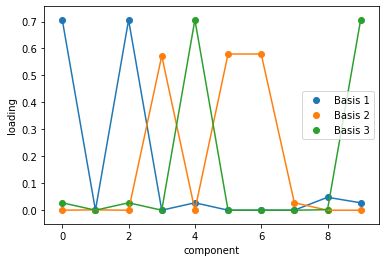

In [18]:
treelet_plots.loadings(loadings)

The modified UH procedure described above is able to recover the factor structure; as an asside, using the standard treelet algorithm with absolue correlations as a similarity measure would give the same results. 

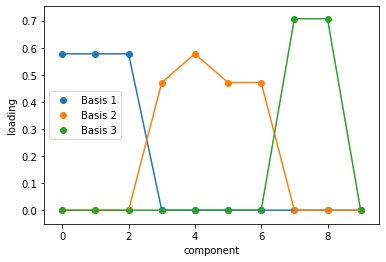

In [19]:
tree = trees.unbalanced_haar_treelet(X = X,L = 9)
loadings = basis_selection.best_basis(tree,3,X)[0]["basis"]
treelet_plots.loadings(loadings)

## Uncorrelated factors and non-overlapping loading vectors

With non-overlapping loadings UH identifies factor structure, however the procedure is not robust to noise...

In [21]:
X = pd.read_csv("../../data/3_uncorrelated_factors.csv").to_numpy()

tree = trees.unbalanced_haar_treelet(X = X,L = 9)
loadings = basis_selection.best_basis(tree,3,X)[0]["basis"]
loadings

array([[0.57735027, 0.        , 0.        ],
       [0.57735027, 0.        , 0.        ],
       [0.57735027, 0.        , 0.        ],
       [0.        , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.70710678],
       [0.        , 0.        , 0.70710678],
       [0.        , 0.        , 0.        ]])

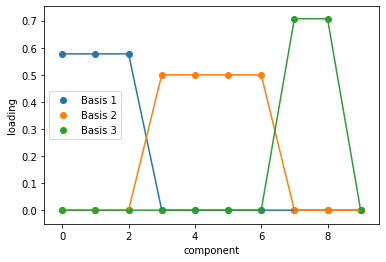

In [22]:
treelet_plots.loadings(loadings)

## Correlated factors and non-overlapping loading vectors 

As with the previous example UH is able to identify the factor structure. 

In [23]:
X = pd.read_csv("../../data/3_correlated_factors.csv").to_numpy()

tree = trees.unbalanced_haar_treelet(X = X,L = 9)
loadings = basis_selection.best_basis(tree,3,X)[0]["basis"]
loadings

array([[ 0.5       ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ],
       [ 0.        ,  0.36514837, -0.2981424 ],
       [ 0.        ,  0.36514837, -0.2981424 ],
       [ 0.        ,  0.36514837, -0.2981424 ],
       [ 0.        ,  0.4472136 , -0.36514837],
       [ 0.        ,  0.4472136 ,  0.54772256],
       [ 0.        ,  0.4472136 ,  0.54772256]])

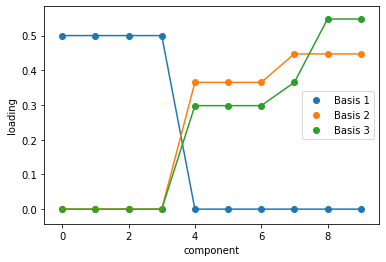

In [24]:
treelet_plots.loadings(loadings)

## Uncorrelated factors and overlapping loading vectors $(p < n)$

Here we see clearly how the UH transform is not robust to noise. The procedure effectively maps each correlation to $-1$ or $1$...

In [28]:
X = pd.read_csv("../../data/3_overlapping_vectors_low_dim.csv").to_numpy()

tree = trees.unbalanced_haar_treelet(X = X,L = 9)
loadings = basis_selection.best_basis(tree,3,X)[0]["basis"]

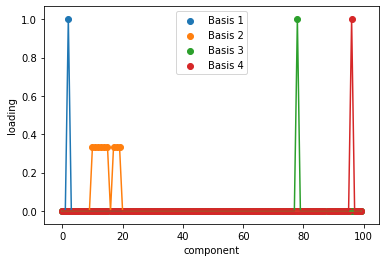

In [29]:
treelet_plots.loadings(loadings)